# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Package setup

In [1]:
# Basic packages
import time
import random
import numpy as np
import pandas as pd

# Math packages
import math
from scipy.signal import spectrogram

# Plot packages
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler, random_split

# ML Packages
from sklearn.model_selection import KFold


## Basic functions setup

In [2]:
# Set random seed
# Executing `set_seed(seed=seed)` you are setting the seed to ensure reproducibility.
# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed = None, seed_torch = True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [3]:
# @title Set device (GPU or CPU). Execute `set_device()` especially if torch modules used.
# inform the user if the notebook uses GPU or CPU.

def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
            "if possible, in the menu under `Runtime` -> "
            "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device


In [4]:
# plot settings

def plot_loss_accuracy(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc):
    epochs = len(train_loss)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label = 'Training')
    ax1.plot(list(range(epochs)), val_loss, label = 'Validation')
    ax1.plot(list(range(epochs)), test_loss, label = 'Testing')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label = 'Training')
    ax2.plot(list(range(epochs)), val_acc, label = 'Validation')
    ax2.plot(list(range(epochs)), test_acc, label = 'Testing')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    
    fig.set_size_inches(15.5, 5.5)
    plt.show()
    

In [5]:
# Norm
def calculate_frobenius_norm(model):
    norm = 0.0
    for param in model.parameters():
        norm += torch.sum(param ** 2)
    norm = norm ** 0.5
    return norm

def L1_norm(model):
    return sum(p.abs().sum() for p in model.parameters())

def L2_norm(model):
    return sum(p.pow(2.0).sum() for p in model.parameters())


## DataLoader setup

In [6]:
class CerealTimeKillersDataset(Dataset):
    """Spectrogram dataset for torch"""

    def __init__(self, df, transform = None):
        self.ori_dataframe = df
        self.transform = transform

    def __len__(self):
        return len(self.ori_dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        spectrogram = self.ori_dataframe.iloc[idx, -1]
        spectrogram = torch.tensor(spectrogram)
        if self.transform:
            spectrogram = self.transform(spectrogram)
        
        labels = self.ori_dataframe.iloc[idx, :-1]
        labels = torch.tensor(labels).type(torch.FloatTensor)
        if self.transform:
            labels = self.transform(labels)
        
        return (spectrogram, labels)
    

In [7]:
def get_specgram(df, labels, winlen = None, stride = 1, nperseg = 256, fs = 129):
    """
    Spectrogram from EEG data
    
    Inputs:
    df (pandas.DataFrame): EEG dataframe
    labels (CerealTimeKillersLabels): Electrode labels used for model prediction
    winlen (None/int): Time window for input sampling (for the whole timepoints, Default is None)
    stride (int): Temporal leap for input sampling (Default is 1)
    nperseg (int): N per seg of spectrogram (Default is 256)
    fs (int): Framerate of spectrogram (Default is 128)
    
    Returns:
    data (np.array): EEG data spectrogram with [samplepoint, frequency, time, channel]
    """
    
    # Load selected electrodes
    df = pd.DataFrame(df, columns = labels)
    d = np.array(df, dtype = float) # Switching from pandas to numpy array as this might be more comfortable for people
    
    full_spec = []
    for idx, d2 in enumerate(d.T):
        _, _, Sxx = spectrogram(d2, nperseg = nperseg, fs = fs)
        full_spec.append(Sxx)
        
    #DIMENSIONS OF FULL_SPEC WITHOUT WINDOWING (I.E. FULL WINDOWING)
    #DIMENSION 1: 1                      - FOR DIMENSIONAL CONSISTENCY
    #DIMENSION 2: CHANNELS  (DEFAULT=14) - MIGHT CHANGE (SO NOT REALLY DEFAULT BUT OK)
    #DIMENSION 3: FREQUENCY (DEFAULT=129)
    #DIMENSION 4: TIME      (DEFAULT=170) - MIGHT CHANGE AS WELL OK - WE ARE WORKING ON IT
    
    full_spec = np.vstack([full_spec])
    full_spec = np.moveaxis(full_spec, 0, 0)
    if winlen == None:
        return np.array([full_spec])
    
    i = 0
    full_spec_wind = []
    # STRICK THE FOLLOWING LOOP ON THE TIME (WINDOW) DIMENSION!
    while i * stride + winlen < full_spec.shape[2]:
        full_spec_wind.append(full_spec[: , : , i * stride : i * stride + winlen])
        i += 1
    
    #DIMENSIONS OF FULL_SPEC WITH WINDOWING    (FULL_SPEC_WIND) 
    #DIMENSION 1: SAMPLE    (NO DEFAULT - SORRY)
    #DIMENSION 2: CHANNELS  (DEFAULT=14) - MIGHT CHANGE (SO NOT REALLY DEFAULT BUT OK)
    #DIMENSION 3: FREQUENCY (DEFAULT=129)
    #DIMENSION 4: WINDOWS   (DEFAULT=1)
    
    full_spec_wind = np.array(full_spec_wind)
    return full_spec_wind


In [8]:
def CerealTimeKillersDataLoader(dir_base, label_class, label_range, 
                                dataset_mix = True, 
                                winlen = None, stride = 1, nperseg = 256, fs = 129,
                                transform = None):
    """
    Cereal Time Killers Data Loader
    
    Inputs:
    dir_base (str): Working space dictionary
    label_class (CerealTimeKillersLabels): Labels used for model prediction
    label_range (1*2 list): The [min, max] of emotional states for transformation
    dataset_mix (bool): Whether to allow between-subject and between-game dataset mixture (Default is True)
    winlen (None/int): Time window for input sampling (for the whole timepoints, Default is None)
    stride (int): Temporal leap for input sampling (Default is 1)
    nperseg (int): N per seg of spectrogram (Default is 256)
    fs (int): Framerate of spectrogram (Default is 128)
    transform (torchvision.transforms.transforms.Compose): Torch transormfation (Default is None)
    
    Returns:
    FullDataset (CerealTimeKillersDatase list): full data with EEG spectrogram and fixed labels (information and/or emotional states) in CerealTimeKillersLabels
        FullDataset[i]: ith datapoint of [spectrogram, labels]
    DataSize (Tuple): Data size for single point as (Input size as tuple, Output size as int)
    ExpIndex (pandas.DataFrame): Corresponsing subject and game (as two columns) with shared row indices from FullDataset
    """
    
    specgram_name = 'full_specgram_1'
    
    # Load label & EEG data
    labels_df = pd.read_csv(f'{dir_base}GameLabels.csv')
    spec_df = pd.DataFrame(columns = label_class.fixed + [specgram_name], dtype = float)
    index_df = pd.DataFrame(columns = ['subject', 'game'], dtype = int)
    
    # Create spectrogram dataframe
    for idx in range(labels_df.shape[0]): 
        
        # Load info and fixed labels
        subject = labels_df['subject'].iloc[idx]
        game = labels_df['game'].iloc[idx]
        fixed_labels = labels_df[label_class.fixed].iloc[idx]
        fixed_labels = list(np.array(np.array(fixed_labels, dtype = 'float') - label_range[0]) / (label_range[1] - label_range[0]))
        
        # You can also just paste in the Directory of the csv file - on windows you may have to change the slash direction
        DirComb = f'{dir_base}GAMEEMO/(S{str(subject).zfill(2)})/Preprocessed EEG Data/.csv format/S{str(subject).zfill(2)}G{str(game)}AllChannels.csv'
        CsvSpec = pd.read_csv(DirComb, sep = ',')
        
        # Get EEG spectrogram
        spec_EEG = get_specgram(CsvSpec, label_class.electrode, 
                                winlen = winlen, stride = stride, nperseg = nperseg, fs = fs)
        
        # Add new data to dataframe
        new_spec_list, new_index_list = list(), list()
        if dataset_mix:
            for i in range(spec_EEG.shape[0]):
                new_spec_list.append(fixed_labels + [spec_EEG[i]])
                new_index_list.append([subject, game])
        else:
            new_spec_list.append(fixed_labels + [spec_EEG])
            new_index_list.append([subject, game])
        
        # Update dataframe
        new_spec_df = pd.DataFrame(new_spec_list, columns = label_class.fixed + [specgram_name], dtype = float)
        spec_df = pd.concat([spec_df, new_spec_df], ignore_index = True)    
        new_index_df = pd.DataFrame(new_index_list, columns = ['subject', 'game'], dtype = int)
        index_df = pd.concat([index_df, new_index_df], ignore_index = True)
    
    # Output
    final_df = CerealTimeKillersDataset(df = spec_df, transform = transform)
    data_size = (tuple(final_df[0][0].shape), tuple(final_df[0][1].shape))

    return final_df, data_size, index_df


In [9]:
def CerealTimeKillersDataSplitter(full_dataset, exp_index, 
                                  allocation_test = None, 
                                  test_ratio = 0.2, target_test = [], k_folds = 10, 
                                  batch_size_train = 16, batch_size_test = 32, 
                                  seed = 0, generator = None):
    """
    Cereal Time Killers Data Splitter
    
    Inputs:
    full_dataset (CerealTimeKillersDataset): full data with EEG spectrogram and experimental labels (information and emotional states)
        full_dataset[i]: ith data for a specific subject and game of {'spectrogram': spectrogram, 'labels': labels}
    exp_index (pandas.DataFrame): Corresponsing subject and game (as two columns) with shared row indices from full_dataset
    allocation_test (None/str): Which to be based for allocating testing dataset (Default is None) # [None, 'subject', 'game']
    test_ratio (float) Proportion of data used for testing when Allocation_test == None (Default is 0.2)
    target_test (list): Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None (Default is [])
    k_folds (int): Number for K-folds for training vs validation (Default is 10)
    batch_size_train (int): Number of examples per minibatch during training (Default is 16)
    batch_size_test (int): Number of examples per minibatch during validation/testing (Default is 1)
    seed (int): Random seed for reproducibility (Default is 0)
    generator (torch._C.Generator): Torch generator for reproducibility (Default is None)
    
    Returns:
    SplittedDataset (dict): Full dataset splitted in {'train': training, 'val': validation, 'test': testing}
        SplittedDataset['train'][fold].dataset (CerealTimeKillersDataset): Training dataset in nth fold
        SplittedDataset['val'][fold].dataset (CerealTimeKillersDataset): Validation dataset in nth fold
        SplittedDataset['test'].dataset (CerealTimeKillersDataset): Testing dataset outside folds
    SplittedDataLength (dict): Length of dataset in {'train': training, 'val': validation, 'test': testing}
    """
    
    # Split into train/val and test datasets
    train_set_index, test_set_index = list(), list()
    if allocation_test == None:
        test_size = int(test_ratio * len(full_dataset))
        train_size = len(full_dataset) - test_size
        train_set_orig, test_set_orig = random_split(full_dataset, 
                                                     [train_size, test_size], 
                                                     generator = generator)
    elif (allocation_test == 'subject') or (allocation_test == 'game'):
        train_set_index = exp_index[~exp_index[allocation_test].isin(target_test)].index.tolist()
        test_set_index = exp_index[exp_index[allocation_test].isin(target_test)].index.tolist()
        train_set_orig = Subset(full_dataset, train_set_index)
        test_set_orig = Subset(full_dataset, test_set_index)
    else:
        print("Allocate testing dataset based on one of the 'Subject', 'Game', or None.")
        return None
    
    # Test dataset loader
    test_loader = DataLoader(test_set_orig,
                             batch_size = batch_size_test,
                             num_workers = 0,
                             generator = g_seed)
    
    # K-fold Cross Validator
    train_loader, val_loader = [[]] * k_folds, [[]] * k_folds
    kfold = KFold(n_splits = k_folds, shuffle = True, random_state = seed)
    for fold, (train_i, val_i) in enumerate(kfold.split(train_set_orig)):
        
        # Sample train/test dataset from indices
        train_sampler = SubsetRandomSampler(train_i, generator = g_seed)
        val_sampler = SubsetRandomSampler(val_i, generator = g_seed)
        
        # Train/Validation dataset loader
        train_loader[fold] = DataLoader(train_set_orig,
                                        sampler = train_sampler,
                                        batch_size = batch_size_train,
                                        num_workers = 0,
                                        generator = generator)
        val_loader[fold] = DataLoader(train_set_orig,
                                      sampler = val_sampler,
                                      batch_size = batch_size_test,
                                      num_workers = 0,
                                      generator = generator)
    
    # return datasplitter
    data_loader = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    data_length = {'train': len(train_sampler), 'val': len(val_sampler), 'test': len(test_set_orig)}
    return data_loader, data_length


## Neural network setup

In [10]:
def train(args, model, train_loader, optimizer = None, criterion = nn.MSELoss()):
    
    model.train()

    for (data, target) in train_loader:
        data, target = data.type(torch.float).to(args['device']), target.type(torch.float).to(args['device'])
        optimizer.zero_grad() 
        output = model(data)
        
        loss = criterion(output, target) + args['l1'] * L1_norm(model) + args['l2'] * L2_norm(model)
        loss.backward()
        
        optimizer.step()


In [11]:
def test(args, model, test_loader, criterion = nn.MSELoss()):
    
    model.eval()
    
    eval_loss = 0.0
    acc = 0.0
    total = 0
    with torch.no_grad():
        for (data, target) in test_loader:
            data, target = data.type(torch.float).to(args['device']), target.type(torch.float).to(args['device'])
            output = model(data)
            
            loss = criterion(output, target)
            eval_loss += loss.item()
            
            _, predicted = torch.max(output, 1)
            _, labels = torch.max(target, 1)
            acc += (predicted == labels).sum().item()
            total += target.size(0)
            
    return eval_loss / len(test_loader), acc * 100 / total


In [12]:
def simulation(args, model, train_loader, val_loader, test_loader, 
                                    optimizer = None, criterion = nn.MSELoss()):
    
    model = model.to(args['device'])
    
    val_loss_list, train_loss_list, test_loss_list = [], [], []
    val_acc_list, train_acc_list, test_acc_list = [], [], []
    param_norm_list = []
    for epoch in tqdm(range(args['epochs'])):
        
        train(args, model, train_loader, optimizer = optimizer, criterion = criterion)
        param_norm = calculate_frobenius_norm(model)
        
        train_loss, train_acc = test(args, model, train_loader, criterion = criterion)
        val_loss, val_acc = test(args, model, val_loader, criterion = criterion)
        test_loss, test_acc = test(args, model, test_loader, criterion = criterion)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)
        param_norm_list.append(param_norm)
        
        if ((epoch + 1) % 10 == 0) or (epoch + 1 == args['epochs']):
            print('-----Epoch ', epoch + 1, '/', args['epochs'])
            print('Train/Val/TEST MSE:', train_loss, val_loss, test_loss)
            print('Train/Val/TEST Accuracy:', train_acc, val_acc, test_acc)

    plot_loss_accuracy(train_loss_list, val_loss_list, test_loss_list, train_acc_list, val_acc_list, test_acc_list)

    return (train_loss_list, val_loss_list, test_loss_list), (train_acc_list, val_acc_list, test_acc_list), param_norm_list, model


In [13]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model = simulation(args, model,
                                                                         TrainDataLoader[fold],
                                                                         ValDataLoader[fold],
                                                                         TestDataLoader,
                                                                         optimizer = optimizer,
                                                                         criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, -1], loss_list[1, -1], loss_list[2, -1]])
        acc.append([np.max(acc_list[0]), np.max(acc_list[1]), np.max(acc_list[2])])
        param.append(param_norm_list[-1])
        models.append(trained_model)
    
    print('Train/Val/Test Final MSE:', list(loss[-1]))
    print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models


## Model settings - Change models here!

In [14]:
class CTK_CRNN_Net(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTK_CRNN_Net, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [(3, 2), (10, 2)]
        pool_kernel = [(2, 2), (2, 2)]
        rnn_layer = [1]
        rnn_unit = [128]
        rnn_drop = [0]
        fc_unit = []
        drop_out = []
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[1], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - np.array(conv_kernel[0]) + 1.0) / np.array(pool_kernel[0]))
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - np.array(conv_kernel[1]) + 1.0) / np.array(pool_kernel[1]))
        
        fc_input_size = np.int(np.prod(img_size) * conv_channel[1])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0])   # for simple RNN and GRU
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.sigmoid(x)
        
        return x


In [15]:
class YourNet(nn.Module):
    def __init__(self, input_shape, out_size):

        super(YourNet, self).__init__()
        
        # Model hyperparametres (layer by layer)
        ...
        
        # Hidden layers
        ...

    def forward(self, x):
        ...
        
        return x


In [16]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTK_CRNN_Net(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


## Input settings - Change hypermatres here!

In [17]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arounsal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arounsal']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction
    

In [18]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 20 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 10 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 150,
    'lr': 5e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [19]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: ((window), channel, frequency, time)')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: ((window), channel, frequency, time)
Single input data size: (15, 14, 129, 20)
Single output data size: (4,)


In [20]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0]) # Comment this if using RNN in your model - this is a known issue in torch.summary


CTK_CRNN_Net(
  (conv1): Conv2d(14, 5, kernel_size=(3, 2), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 5, kernel_size=(10, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(540, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.10018647611141204 0.08600854987485541 0.11219760332079161
Train/Val/TEST Accuracy: 37.68115942028985 33.333333333333336 14.285714285714286
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.10028947591781616 0.08762905011988348 0.1206082492578952
Train/Val/TEST Accuracy: 34.78260869565217 11.11111111111111 19.047619047619047
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.09155967384576798 0.08773695656822787 0.11217402520456485
Train/Val/TEST Accuracy: 39.130434782608695 27.77777777777778 14.285714285714286
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.09082332998514175 0.08473160511089696 0.10939121685389962
Train/Val/TEST Accuracy: 36.231884057971016 27.77777777777778 23.80952380952381
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.08607116043567657 0.08429635005692641 0.1105228875364576
Train/Val/TEST Accuracy: 42.028985507246375 16.666666666666668 19.047619047619047
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.06909495517611504 0.0775224512649907 0.11123595320

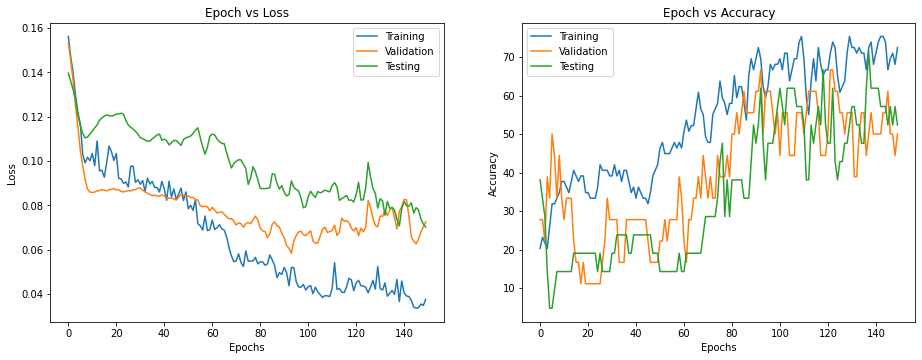


2/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.09442361295223237 0.09178673434588644 0.1152137207488219
Train/Val/TEST Accuracy: 44.927536231884055 27.77777777777778 14.285714285714286
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.08752591609954834 0.08651341891123189 0.11417633858287618
Train/Val/TEST Accuracy: 43.47826086956522 33.333333333333336 19.047619047619047
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.0833085224032402 0.08683766786836916 0.1179856386567865
Train/Val/TEST Accuracy: 43.47826086956522 33.333333333333336 23.80952380952381
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.07435145229101181 0.0838167770869202 0.11292506381869316
Train/Val/TEST Accuracy: 52.17391304347826 44.44444444444444 23.80952380952381
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.0618357352912426 0.08299710844746894 0.11377000839759906
Train/Val/TEST Accuracy: 57.971014492753625 38.888888888888886 28.571428571428573
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.04809250310063362 0.08042753141166435 0.10582619719207

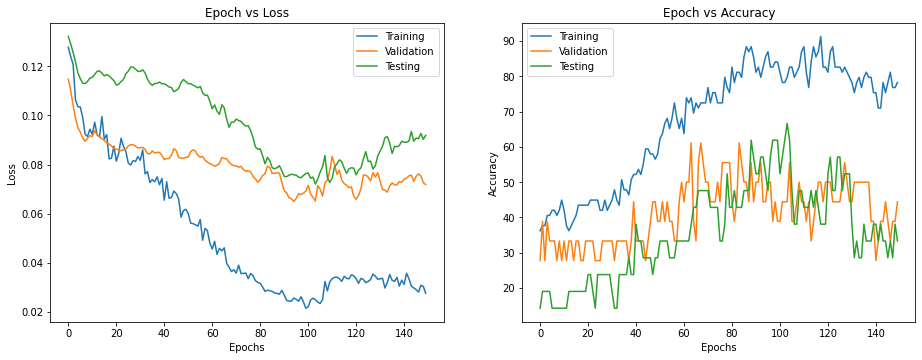


3/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.08971356004476547 0.11368860896019374 0.12315597254339428
Train/Val/TEST Accuracy: 38.57142857142857 47.05882352941177 14.285714285714286
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.08614257276058197 0.11925472505390644 0.13174078884046703
Train/Val/TEST Accuracy: 28.571428571428573 47.05882352941177 14.285714285714286
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.07721899971365928 0.10929245479843196 0.12120310793675128
Train/Val/TEST Accuracy: 35.714285714285715 47.05882352941177 19.047619047619047
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.07527693510055541 0.10688858172472786 0.1225657742027016
Train/Val/TEST Accuracy: 38.57142857142857 47.05882352941177 14.285714285714286
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.061760013550519945 0.10584368304732968 0.12312370605234589
Train/Val/TEST Accuracy: 44.285714285714285 52.94117647058823 14.285714285714286
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.05675174668431282 0.10455978092025309 0.122435484

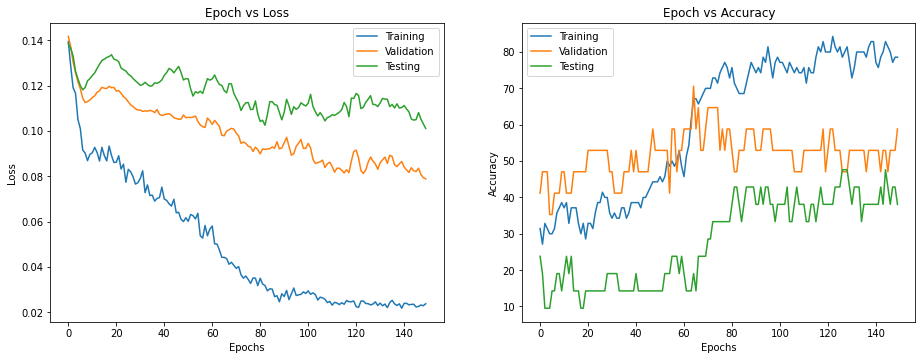


4/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.09445599466562271 0.1034552021061673 0.11130948936832803
Train/Val/TEST Accuracy: 34.285714285714285 23.529411764705884 19.047619047619047
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.08625342100858688 0.10380839129142902 0.12272172208343234
Train/Val/TEST Accuracy: 47.142857142857146 23.529411764705884 23.80952380952381
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.08040416240692139 0.10693026564138777 0.11348513611370609
Train/Val/TEST Accuracy: 28.571428571428573 29.41176470588235 14.285714285714286
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.07543861046433449 0.10524980417069267 0.10724576952911559
Train/Val/TEST Accuracy: 40.0 17.647058823529413 23.80952380952381
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.06626847460865974 0.10511211968739242 0.10145624412134999
Train/Val/TEST Accuracy: 44.285714285714285 5.882352941176471 23.80952380952381
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.06341730207204818 0.11673909140860333 0.09960285503239859
Trai

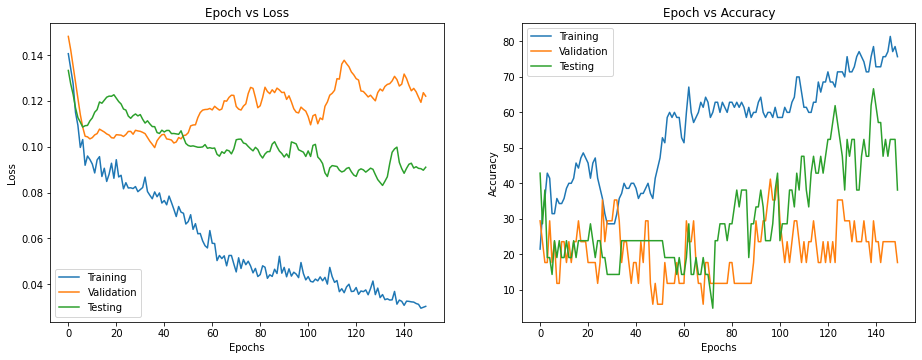


5/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.09014149308204651 0.11328070698415532 0.1137538920821888
Train/Val/TEST Accuracy: 37.142857142857146 41.1764705882353 14.285714285714286
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.07934911102056504 0.12615845965988495 0.11429263930767775
Train/Val/TEST Accuracy: 42.857142857142854 35.294117647058826 14.285714285714286
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.0714856043457985 0.1253077365896281 0.11085737589746714
Train/Val/TEST Accuracy: 52.857142857142854 47.05882352941177 14.285714285714286
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.06726372838020325 0.127652471556383 0.11001377796665543
Train/Val/TEST Accuracy: 57.142857142857146 23.529411764705884 14.285714285714286
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.05301717594265938 0.11657042976687937 0.10361443255983648
Train/Val/TEST Accuracy: 62.857142857142854 35.294117647058826 14.285714285714286
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.037457346171140674 0.1111516166916665 0.0957973805

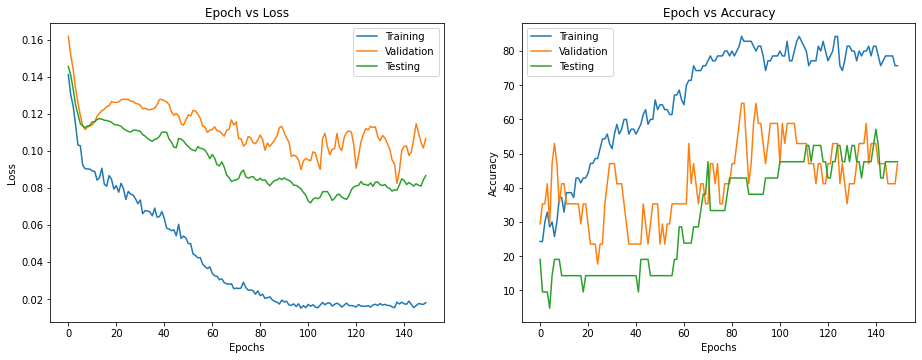

Train/Val/Test Final MSE: [0.018096582777798177, 0.10656724092276658, 0.0865553201930154]
Train/Val/Test Maximum Accuracy: [84.28571428571429, 64.70588235294117, 57.142857142857146]


In [21]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args,
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)


In [22]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.027497006393969063, 0.09038518959461572, 0.08818381257976096]
Train/Val/Test Average Accuracy: [83.33333333333334, 60.84967320261438, 61.90476190476191]


## Single prediction results

In [23]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target) in enumerate(ShowDataset):
        data, target = data.type(torch.float).to(args['device']), target.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
            
        _, predicted = torch.max(output, 1)
        _, labels = torch.max(target, 1)
        eval_acc = (predicted == labels).sum().item() * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0].detach().numpy())
            print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0].detach().numpy())
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.15913697 0.69487053 0.20690824 0.19508336] with label  1
Target Example: [0.         1.         0.11111111 0.        ] with label  1
------- MSE: 0.04141579568386078  Accuracy: 100.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.5466677  0.08888986 0.5442583  0.31180835] with label  0
Target Example: [1. 0. 1. 0.] with label  0
------- MSE: 0.12958413362503052  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.3074385  0.31817055 0.43371126 0.41288468] with label  2
Target Example: [0.7777778  0.         0.22222222 0.        ] with label  0
------- MSE: 0.1344132423400879  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.2745099  0.05254502 0.61773354 0.4081768 ] with label  2
Target Example: [0.         0.         0.44444445 0.7777778 ] with label  3
------- MSE: 0.06118766590952873  Accuracy: 0.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.37950107 0.5299141  0.3686309  0.2493472 ] with label  1
Target E